# LABORATORY 4

In [ ]:
dfLog = spark.read.load("/data/students/bigdata_internet/lab4/log_tcp_complete_classes.txt",\
                             format = "csv",
                             sep = " ",
                             header = True,
                             inferSchema = True)

In [ ]:
dfLog.createOrReplaceTempView("logTable")

#### 1.1 -  How many columns/features does the file have?

In [52]:
print("Number of columns: ", len(dfLog.columns))

Number of columns:  207


#### 1.2 - How many TCP connections are there in the log?

In [53]:
# Count how many TCP connections are in the log
n_TCPConnections = dfLog.count()
print("Number of TCP connections: ", n_TCPConnections)

Number of TCP connections:  100000


#### 2.0.1 - How many classes are there in the file?

In [54]:
# create a dataframe with only the class labels
dfclassLabels = dfLog.select(dfLog.columns[206]).distinct()
print("Number of classes: ",dfclassLabels.count())

Number of classes:  10


#### 2.0.2 - Can you list all of them?

In [55]:
dfclassLabels.show()

+---------------+
|      class:207|
+---------------+
|   class:google|
|   class:amazon|
|class:instagram|
| class:facebook|
|  class:netflix|
|     class:ebay|
|  class:spotify|
| class:linkedin|
|  class:youtube|
|     class:bing|
+---------------+



#### 2.0.3 - How many connections per web service are present in the DataFrame?

In [56]:
dfServiceGroup = spark.sql("SELECT `class:207`, count(*) as Nconnections\
                          FROM logTable\
                          GROUP BY `class:207`")

There are 10000 connections per web service

#### 2.1 - Select features

In [57]:
feat_cols = [dfLog.columns[2], dfLog.columns[6], dfLog.columns[7],\
             dfLog.columns[16], dfLog.columns[20],dfLog.columns[21],\
             dfLog.columns[30], dfLog.columns[41], dfLog.columns[44],\
             dfLog.columns[51], dfLog.columns[50], dfLog.columns[57],\
             dfLog.columns[69], dfLog.columns[70] , dfLog.columns[71],\
             dfLog.columns[98], dfLog.columns[99] , dfLog.columns[100]]
# dfFeatures contains features plus class labels
dfFeatures = dfLog.select(dfLog.columns[2], dfLog.columns[6], dfLog.columns[7],\
                          dfLog.columns[16], dfLog.columns[20],dfLog.columns[21],\
                          dfLog.columns[30], dfLog.columns[41], dfLog.columns[44],\
                          dfLog.columns[51], dfLog.columns[50], dfLog.columns[57],\
                          dfLog.columns[69], dfLog.columns[70] , dfLog.columns[71],\
                          dfLog.columns[98], dfLog.columns[99] , dfLog.columns[100],\
                          dfLog.columns[206])
# selected features: c_pkts_all:3,c_bytes_uniq:7,c_pkts_data:8,s_pkts_all:17
#s_bytes_uniq:21,s_pkts_data:22,durat:31,p2p_st:59,con_t:42, c_rtt_avg:45
#s_rtt_avg:52,c_ttl_max:51, s_ttl_max:58,c_mss:70, c_mss_max
#c_mss_min:72,s_cwin_max,_cwin_min:100,s_cwin_ini:101

#### 2.1.1.- Does it make sense to use the IP addresses + ports (`#31#c_ip:1`,`c_port:2`, `s_ip:15`, `s_port:16`) as features?

No it does not make sense because IP adresses and ports are related to clients or servers and do not add any information to the possible service they are using.

#### 2.1.2. Would it be fair to use the Fully Qualified Domain Name (FQDN,`fqdn:127`, for instance `www.google.com`) for the classification?
No it wouldn't be fair because is strictly correlated to the class we want to classify. It's like using the labels itself to classify.

In [58]:
# split the data in train and test sets
# 75% for training 25% for test
# set seed = 309 for reproducibility
dfTrain, dfTest = dfFeatures.randomSplit([0.75, 0.25], 309)

In [59]:
# Using vector assembler
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = feat_cols, outputCol = 'features')

In [60]:
# Normalize the data
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler\
(inputCol='features', outputCol="scaledFeatures", withStd=True, withMean=True)

In [61]:
from pyspark.ml.feature import StringIndexer
# handle categorical features
indexerTCP = StringIndexer(inputCol=dfLog.columns[41], outputCol="tcp_type")
indexer = StringIndexer(inputCol="class:207",outputCol="label")

In [62]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = [indexerTCP, vectorAssembler, scaler,indexer])
preprocess = pipeline.fit(dfTrain)
processTestDF = preprocess.transform(dfTest)
processTrainDF = preprocess.transform(dfTrain)

#### MODEL 1: Random forest classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
import time
start_time = time.time()
rf = RandomForestClassifier(labelCol="label",featuresCol="features"\
                            ,maxDepth=18, numTrees=20)
RandomForestModel = rf.fit(processTrainDF)
RandForestTrainDF=RandomForestModel.transform(processTrainDF)
RandForestTestDF = RandomForestModel.transform(processTestDF)
exec_time = time.time() - start_time

#### 2.4.1 How much does it take to train the model (time in seconds), for the different algorithm and parameters?

In [64]:
print(f"Execution time: {exec_time} seconds")

Execution time: 17.181364059448242 seconds


In [65]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
myEvaluator =MulticlassClassificationEvaluator(labelCol="label",\
                    predictionCol="prediction", metricName='accuracy')
print("Accuracy on training is ", myEvaluator.evaluate(RandForestTrainDF))
print("Accuracy on test is ", myEvaluator.evaluate(RandForestTestDF))

Accuracy on training is  0.9968325247584299


[Stage 1435:===============>                                      (7 + 18) / 25]

Accuracy on test is  0.9828017635143186


In [66]:
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F
preds_and_labels = RandForestTestDF.select(['prediction','label'])\
.withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
predictionAndLabels = preds_and_labels.select(['prediction','label']).rdd.map(tuple)

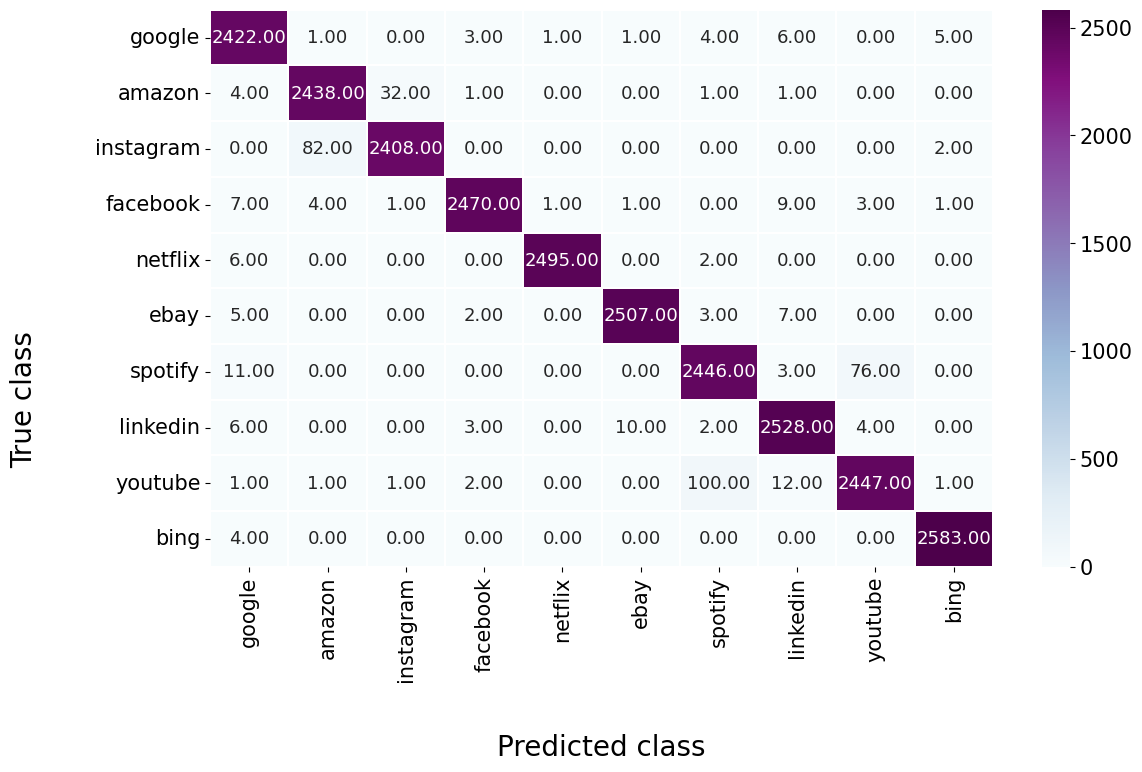

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()
#REPLACE NAME OF YOUR DATAFRAME HERE
classes = RandForestTestDF.select("class:207").distinct().rdd.map(lambda r:r[0]).collect()
classes = [el.replace("class:", "") for el in classes]
fig, ax = plt.subplots(figsize =(12, 8))
fontsize = 15
ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes,
linewidth = 0.2,
cmap="BuPu", annot = True, fmt = ".2f", annot_kws={"fontsize":fontsize-2})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize)
ax.figure.axes[-1].yaxis.label.set_size(fontsize+5)
ax.figure.axes[-1].yaxis.set_label_coords(3,.5)
ax.set_xticklabels(classes, fontsize=fontsize, rotation = 90)
ax.set_yticklabels(classes, fontsize=fontsize, rotation = 0)
ax.set_ylabel("True class", fontsize = fontsize + 5)
ax.set_xlabel("Predicted class", fontsize = fontsize + 5)
ax.yaxis.set_label_coords(-.22,.3)
ax.xaxis.set_label_coords(.5, -.3)
plt.tight_layout()
plt.show()

#### MODEL 2: Decision tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
import time
start_time = time.time()
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features"\
                            , maxDepth=18, impurity="Entropy")
DecisionTreeModel = dt.fit(processTrainDF)
DecTreeTrainDF=DecisionTreeModel.transform(processTrainDF)
DecTreeTestDF = DecisionTreeModel.transform(processTestDF)
exec_time = time.time() - start_time

#### 2.4.1 How much does it take to train the model (time in seconds), for the different algorithm and parameters?

In [69]:
print(f"Execution time: {exec_time} seconds")

Execution time: 5.367742538452148 seconds


In [70]:
print("Accuracy on training is ", myEvaluator.evaluate(DecTreeTrainDF))
print("Accuracy on test is ", myEvaluator.evaluate(DecTreeTestDF))

Accuracy on training is  0.9963781190275718
Accuracy on test is  0.9728720657743178


In [71]:
preds_and_labels = DecTreeTestDF.select(['prediction','label'])\
.withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
predictionAndLabels = preds_and_labels.select(['prediction','label']).rdd.map(tuple)

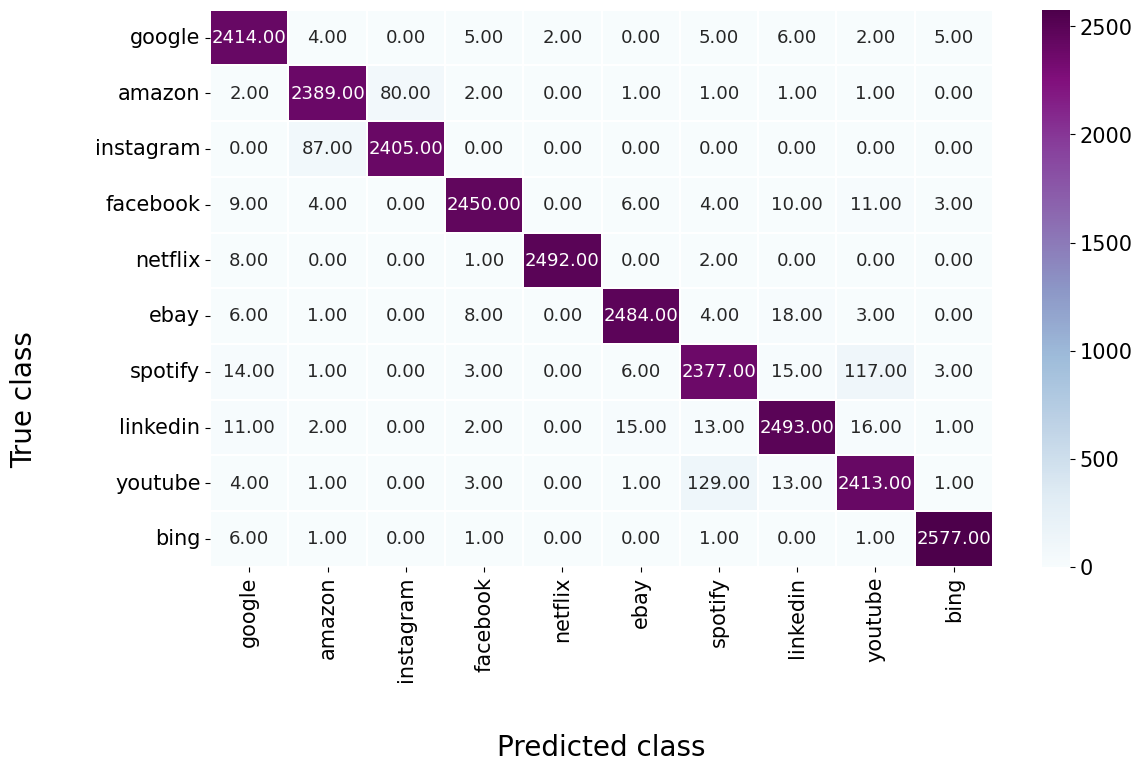

In [72]:
metrics = MulticlassMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()
#REPLACE NAME OF YOUR DATAFRAME HERE
classes = DecTreeTestDF.select("class:207").distinct().rdd.map(lambda r:r[0]).collect()
classes = [el.replace("class:", "") for el in classes]
fig, ax = plt.subplots(figsize =(12, 8))
fontsize = 15
ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes,
linewidth = 0.2,
cmap="BuPu", annot = True, fmt = ".2f", annot_kws={"fontsize":fontsize-2})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize)
ax.figure.axes[-1].yaxis.label.set_size(fontsize+5)
ax.figure.axes[-1].yaxis.set_label_coords(3,.5)
ax.set_xticklabels(classes, fontsize=fontsize, rotation = 90)
ax.set_yticklabels(classes, fontsize=fontsize, rotation = 0)
ax.set_ylabel("True class", fontsize = fontsize + 5)
ax.set_xlabel("Predicted class", fontsize = fontsize + 5)
ax.yaxis.set_label_coords(-.22,.3)
ax.xaxis.set_label_coords(.5, -.3)
plt.tight_layout()
plt.show()

#### 2.5.1 Comment your results: which classes are easier to classify? Which get confused the most?
The two algorithms perform well for all the classes, but the most confused are amazon with instagram and viceversa.

#### 2.5.2 Which classifier performs better? Why do you think it is the case?
The random forest classifier performs slightly better because it uses different trees and the chooses the better one.

In [73]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
trainDf, valDf = processTrainDF.randomSplit([0.75, 0.25])

#### Tuning for Random Forest Classifier

In [ ]:
# tuning random forest model
paramGridRf = ParamGridBuilder().addGrid(rf.maxDepth, [10,20, 25])\
            .addGrid(rf.numTrees, [10,20,30])\
            .addGrid(rf.impurity,["Gini","Entropy"]).build()
cv = CrossValidator(estimator=rf, evaluator=myEvaluator,\
                    estimatorParamMaps=paramGridRf, numFolds=4)
cvModel=cv.fit(trainDf)

In [76]:
rfTrain = cvModel.transform(trainDf)
rfVal = cvModel.transform(valDf)
rfTest = cvModel.transform(processTestDF)

#### 2.6.1 Report the accuracy results for all the parameters you tried. What can you conclude?

In [80]:
import pandas as pd
res_RFC = pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(paramGridRf, cvModel.avgMetrics)
])
res_RFC.columns = ['accuracy', 'maxDepth', 'numTrees', 'entropy']
print(res_RFC)

    accuracy  maxDepth  numTrees  entropy
0   0.956440        10        10     Gini
1   0.959688        10        10  Entropy
2   0.957711        10        20     Gini
3   0.962127        10        20  Entropy
4   0.958953        10        30     Gini
5   0.963730        10        30  Entropy
6   0.977941        20        10     Gini
7   0.978086        20        10  Entropy
8   0.979866        20        20     Gini
9   0.980613        20        20  Entropy
10  0.980152        20        30     Gini
11  0.981166        20        30  Entropy
12  0.977888        25        10     Gini
13  0.977943        25        10  Entropy
14  0.979813        25        20     Gini
15  0.980310        25        20  Entropy
16  0.980384        25        30     Gini
17  0.981185        25        30  Entropy


#### 2.7.1 Report the expected results performance and comment on the results obtained.

In [81]:
print("Accuracy on training: ", myEvaluator.evaluate(rfTrain))
print("Accuracy on validation: ", myEvaluator.evaluate(rfVal))
print("Accuracy on test: ", myEvaluator.evaluate(rfTest))

Accuracy on training:  0.9987175605151132


Accuracy on validation:  0.9815845824411135
Accuracy on test:  0.9817690749493585


As was expected the random classifier performs better. The accuracies of training and test set are slightly different; this means that the model does not overfit.

#### Tuning for Decision Tree Classifier

In [ ]:
paramGridDt = ParamGridBuilder().addGrid(dt.maxDepth, [10,20, 25])\
            .addGrid(dt.impurity,["Gini","Entropy"]).build()
cv = CrossValidator(estimator=dt, evaluator=myEvaluator,\
                    estimatorParamMaps=paramGridDt, numFolds=4)
cvModel=cv.fit(trainDf)

## 3. Cluster users (BONUS TASK)

### 3.1 How many clients are there in the file?

In [5]:
clientsDF = spark.sql('SELECT `#31#c_ip:1` \
                        FROM logTable\
                        GROUP BY `#31#c_ip:1`') 

In [6]:
print("Number of clients: ", clientsDF.count())

[Stage 3:=========================================>            (153 + 47) / 200]

Number of clients:  3844


#### 3.2 What is their average number of connections?

In [7]:
nConnClientsDF = spark.sql('SELECT `#31#c_ip:1`, count(`s_ip:15`) AS n_conn\
                            FROM logTable\
                            GROUP BY `#31#c_ip:1`')
nConnClientsDF.createOrReplaceTempView('nConnTab')

In [8]:
AvgConnDF = spark.sql('SELECT avg(n_conn)\
                        FROM nConnTab')

In [9]:
print("The average number of connection is 26.014")

The average number of connection is 26.014


#### 3.3 Who are the top-5 most active users?

In [10]:
topUsersDF = spark.sql('SELECT `#31#c_ip:1`, n_conn\
                        FROM nConnTab\
                        ORDER BY n_conn DESC')

The top 5 most active users are: 246.25.63.193, 246.25.221.106, 180.102.5.86, 246.25.63.82, 180.102.5.42

In [11]:
# define features
statUserDF = spark.sql\
('SELECT `#31#c_ip:1`, count(`s_ip:15`) AS n_conn, sum(`c_bytes_all:9`) AS Upl_B\
, sum(`s_bytes_all:23`) AS down_B, sum(`s_bytes_retx:25`) AS retr_B\
, avg(`s_rtt_avg:52`) AS avg_RTT, avg(`s_first:33`) AS avg_proc\
                            FROM logTable\
                            GROUP BY `#31#c_ip:1`')

In [12]:
feat_cols = ["n_conn", "Upl_B", "down_B", "retr_B", "avg_RTT", "avg_proc"]
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = feat_cols, outputCol = 'features')

In [13]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol='features',\
        outputCol="scaledFeatures", withStd=True, withMean=True)

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = [vectorAssembler, scaler])
preprocess = pipeline.fit(statUserDF)
processDF = preprocess.transform(statUserDF)

#### K_Means

In [15]:
from pyspark.ml.clustering import KMeans

In [ ]:
kmeans = KMeans(k=50,featuresCol="scaledFeatures",initMode="k-means||")
modelKm = kmeans.fit(processDF)
predictionDF = modelKm.transform(processDF)

In [35]:
from pyspark.ml.evaluation import ClusteringEvaluator
centers = modelKm.clusterCenters()

In [36]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictionDF)
print("Silhouette with squared euclidean distance = " + str(silhouette))
print("SSE: ",modelKm.computeCost(predictionDF))

Silhouette with squared euclidean distance = -0.9096295382108852
SSE:  889.183365057557


#### GMM

In [37]:
from pyspark.ml.clustering import GaussianMixture

In [ ]:
gmm = GaussianMixture(k=2,featuresCol="scaledFeatures")
modelGMM = gmm.fit(processDF)

In [58]:
predictionsDF = modelGMM.transform(processDF)

In [59]:
print("Gaussians weights shown as a DataFrame: ")

Gaussians weights shown as a DataFrame: 


In [60]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictionsDF)
print("Silhouette with squared euclidean distance = " + str(silhouette))
print("SSE: ",modelKm.computeCost(predictionsDF))

Silhouette with squared euclidean distance = 0.8775003705467208
SSE:  889.1833650575571


#### 3.4 provide comments, intuitions and interpretations on the obtained clusters.
For the K-Means algorithm has been choosen a large number of cluster in order to not have an extremly high SSE (Sum of Squared Error). The silhouette value is quite good since it's absolute value is close to 1.
On the other hand, the GMM has better results by keeping a lower number of clusters.